In [3]:
import numpy as np
import random
import math
from PIL import Image

# 지정된 너비, 높이로 씬을 생성합니다.
# 씬에는 두 개의 객체를 포함하고 있습니다.
# 객체가 위치된 픽셀 값은 1.0이고 나머지 픽셀 값은 0.0입니다.
def generate_scene(w, h):
    
    scene = np.zeros((w, h))
    
    # 첫번째 객체 위치를 임의로 선정합니다.
    pos_1_x = random.randrange(0, w) # 0, 1, 2 중 하나
    pos_1_y = random.randrange(0, h) # 0, 1, 2 중 하나
    
    # 두번째 객체 위치를 첫번째 객체 위치와 겹치지 않도록 임의로 선정합니다.
    find_pos_2 = False
    while not find_pos_2:
        pos_2_x = random.randrange(0, w)
        pos_2_y = random.randrange(0, h)
        if pos_1_x == pos_2_x and pos_1_y == pos_2_y:
            continue
        find_pos_2 = True
    
    # 선정된 두 객체 위치에 1.0을 셋팅합니다.
    scene[pos_1_y][pos_1_x] = 1.0
    scene[pos_2_y][pos_2_x] = 1.0    
    
    return scene

# 씬을 이미지 파일로 저장합니다.
def save_image_from_scene(scene, filename):
    im_scene = scene * 255.0    
    im = Image.new('L', (im_scene.shape[0], im_scene.shape[1]))
    im.putdata(im_scene.flatten().tolist())
    im.save(filename)
    
# 씬의 두 객체 간의 거리를 구합니다.
def distance_objects(scene):
        
    pos_x = []
    pos_y = []

    # 두 객체의 위치를 찾습니다.
    for x in range(scene.shape[0]):
        for y in range(scene.shape[1]):
            if scene[y][x] == 1.0:
                pos_x.append(x)
                pos_y.append(y)                

    # 두 객체의 거리를 구합니다.
    dist = math.sqrt(math.pow(pos_x[0] - pos_x[1], 2) + math.pow(pos_y[0] - pos_y[1], 2))
    
    return dist
    
def generate_dataset(count, width, height, dist_threshold, save_file = False):
    
    dataset_x = []
    dataset_y = []
    
    for i in range(count):
        
        scene = generate_scene(width, height)
        dist = distance_objects(scene)
    
        if dist < dist_threshold:
            dist_label = 0 # 두 객체 간의 거리가 가까우면 0을 반환합니다.
        else:
            dist_label = 1 # 두 객체 간의 거리가 멀면 1을 반환합니다.
        
        # 이미지로 저장합니다.
        if save_file :
            filename = './warehouse/rn/' + str(dist_label) + '_' + str(i) + '.png'
            save_image_from_scene(scene, filename)
        
        # 데이터셋을 생성합니다.
        dataset_x.append(scene)
        dataset_y.append(dist_label)
    
    return np.array(dataset_x), np.array(dataset_y)

### 데이터셋 생성 및 구성



In [13]:
count = 200
width = 5
height = 5
dist_threshold = math.sqrt(width*height)/2.0

dataset_X, dataset_Y = generate_dataset(count, width, height, dist_threshold, True)

train_size = int(len(dataset_X) * 0.70)
test_size = len(dataset_X) - train_size

train_X, test_X = dataset_X[0:train_size], dataset_X[train_size:len(dataset_X)]
train_Y, test_Y = dataset_Y[0:train_size], dataset_Y[train_size:len(dataset_Y)]

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2])
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1]*test_X.shape[2])

In [14]:
import keras

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.acc = []
        self.loss = []
        self.val_acc = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.val_loss.append(logs.get('val_loss'))        

Train on 140 samples, validate on 60 samples
Epoch 1/100
140/140 [==============================] - 0s - loss: 0.6930 - acc: 0.5286 - val_loss: 0.6930 - val_acc: 0.4333
Epoch 2/100
140/140 [==============================] - 0s - loss: 0.6918 - acc: 0.5500 - val_loss: 0.6935 - val_acc: 0.4167
Epoch 3/100
140/140 [==============================] - 0s - loss: 0.6891 - acc: 0.6143 - val_loss: 0.6927 - val_acc: 0.4500
Epoch 4/100
140/140 [==============================] - 0s - loss: 0.6821 - acc: 0.6357 - val_loss: 0.6908 - val_acc: 0.4333
Epoch 5/100
140/140 [==============================] - 0s - loss: 0.6662 - acc: 0.6786 - val_loss: 0.6872 - val_acc: 0.5167
Epoch 6/100
140/140 [==============================] - 0s - loss: 0.6383 - acc: 0.7000 - val_loss: 0.6797 - val_acc: 0.5500
Epoch 7/100
140/140 [==============================] - 0s - loss: 0.6048 - acc: 0.7286 - val_loss: 0.6762 - val_acc: 0.6000
Epoch 8/100
140/140 [==============================] - 0s - loss: 0.5633 - acc: 0.7643 

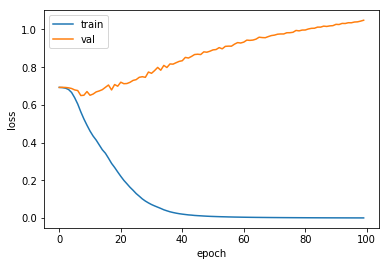

32/60 [===============>..............] - ETA: 0sacc: 75.00%


In [15]:
from keras.models import Sequential
from keras.layers import Dense

# 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim = width * height, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# 모델 엮기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory()
history.init()

# 모델 학습시키기
model.fit(train_X, train_Y, epochs=100, batch_size=10, validation_data = (test_X, test_Y), callbacks=[history])

# 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.loss)
plt.plot(history.val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 모델 평가하기
scores = model.evaluate(test_X, test_Y)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))  

In [ ]:
def slice_1(t):
    return t[:, 0, :, :]

def slice_2(t):
    return t[:, 1:, :, :]

def slice_3(t):
    return t[:, 0, :]

def slice_4(t):
    return t[:, 1:, :]

In [ ]:
input1 = Input((50, 200, 3))
input2 = Input((mxlen,))
cnn_features = conv_net(input1)
embedding_layer = embedding_layer(tokenizer.word_index, get_embeddings_index(), mxlen)
embedding = embedding_layer(input2)
# embedding = Embedding(mxlen, embedding_dim)(input2)
bi_lstm = Bidirectional(LSTM(lstm_unit, implementation=2, return_sequences=False,
                             recurrent_regularizer=regularizers.l2(l2_norm), recurrent_dropout=0.25))
lstm_encode = bi_lstm(embedding)
shapes = cnn_features.shape
w, h = shapes[1], shapes[2]

In [ ]:
feature_map = dataset
feature_map_width = 3
feature_map_height = 3

features = []
for k1 in range(feature_map_width):
    features1 = slice_1(feature_map)
    feature_map = slice_2(feature_map)
    for k2 in range(feature_map_height):
        features2 = slice_3(features1)
        features1 = slice_4(features1)
        features.append(features2)
        
np_f = np.array(features)
print(np_f.shape)
print(np_f)

In [ ]:
feature_map = dataset
feature_map_width = 3
feature_map_height = 3

features_test = []
for fw in range(feature_map_width):
    for fh in range(feature_map_height):
        features_test.append(feature_map[:, fw, fh, :])

np_ft = np.array(features_test)
print(np_ft.shape)
print(np_ft)

In [ ]:
np_fm.shape

In [ ]:
np_fm

In [ ]:
relations = []

for feature1 in features:
    for feature2 in features:
        relations.append(np.concatenate([feature1, feature2]))

In [ ]:
np_r = np.array(relations)
np_r.shape

In [ ]:
np_r